In [116]:
import time
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy.linalg import inv, qr, svd, cholesky
from scipy.linalg import solve_triangular

import warnings
warnings.simplefilter("ignore")

## Q1.a

Denote by $\beta$ the linear regression coefficients, by $X$ the predictors, and by $y$ the response variable.


### Naive linear algebra derivation

$$
X \beta = y \\
X^{T}X \beta = X^{T}y \\
\beta = (X^{T}X)^{-1}X^{T}y
$$

### QR decomposition derivation

In this case, if $X$ is an $n\times p$ matrix of full rank, we have $X = QR$ where $Q$ is a $n\times p$ orthonormal matrix and $R$ is a $p\times p$ upper triangular matrix. 

Thus, we can derive

$$
X \beta = y \\
X^{T}X \beta = X^{T}y \\
(QR)^{T} QR \beta = (QR)^{T}y \\
R^{T}(Q^{T}Q)R \beta = R^{T}Q^{T}y \\
R^{T}R \beta = R^{T}Q^{T}y \\
(R^{T})^{-1}R^{T}R \beta = (R^{T})^{-1}R^{T}Q^{T}y \\
R \beta = Q^{T}y \\
\beta = R^{-1}Q^{T}y
$$

### SVD derivation

In this case, if $X$ is an $n\times p$ matrix of full rank, we have $X = USV^{T}$ where $U$ is a $n\times n$ unitary matrix and $S$ is an $n\times p$ matrix consisting of non-negative singular values and zeros else where, and $V^{T}$ is an $p\times p$ unitary matrix. 

Besides, as $U, V$ are unitary matrices, we have 

$$
UU^{T} = U^{T}U = I \\
VV^{T} = V^{T}V = I
$$

Thus, we can derive

$$
X \beta = y \\
USV^{T} \beta = y \\
(USV^{T})^{-1}USV^{T} \beta = (USV^{T})^{-1}y \\
(V^{T})^{-1}S^{-1}(U^{-1}U)SV^{T} \beta = (V^{T})^{-1}S^{-1}U^{-1}y \\
V(S^{-1}S)V^{T} \beta = VS^{-1}U^{T}y \\
VV^{T} \beta = VS^{-1}U^{T}y \\
\beta = VS^{-1}U^{T}y
$$

### Cholesky decomposition derivation

In this case, if $X$ is an $n\times p$ of full rank, we have $A = X^{T}X$ is positive definite. Then there exists a lower triangular matrix $L$ such at $A = LL^{T}$.

Thus, we can derive

$$
X \beta = y \\
X^{T}X \beta = X^{T}y \\
LL^{T} \beta = X^{T}y \\
L^{T} \beta = L^{-1}X^{T}y \\
\beta = (L^{T})^{-1}L^{-1}X^{T}y
$$

Now, since $L^{T}$ is an upper triangular matrix (row-echelon form), we can solve for $\beta$ using back substitution.

## Q1.b

The `benchmarking` function takes as input the name of the algorithm and given values of $n$ and $p$. It will return the time spent on running the algorithm for solving $\beta$.

In [112]:
def benchmarking(algorithm, n, p):
  
    np.random.seed(123)
    X = np.random.randn(n, p)
    y = np.random.randn(n)

    if algorithm == "Naive linear algebra":
        t = 0
        for i in range(10):
            start = time.time()
            beta = inv(np.dot(X.T, X)).dot(X.T).dot(y)
            end = time.time()
            t += end-start
    elif algorithm == "QR decomposition":
        t = 0
        for i in range(10):
            start = time.time()
            q, r = qr(X)
            beta = np.dot(inv(r), q.T).dot(y) # solve_triangular(r, np.dot(q.T, y))
            end = time.time()
            t += end-start
    elif algorithm == "SVD":
        t = 0
        for i in range(10):
            start = time.time()
            u, s, vT = svd(X)
            s_inv = np.zeros(X.shape).T
            s_inv[:p,:p] = np.diag(1/s)
            beta = np.dot(vT.T, s_inv).dot(u.T).dot(y)
            end = time.time()
            t += end-start
    elif algorithm == "Cholesky decomposition":
        t = 0
        for i in range(10):
            start = time.time()
            L = cholesky(np.dot(X.T, X))
            beta = np.dot(inv(L.T), inv(L)).dot(X.T).dot(y) # solve_triangular(L.T, np.dot(inv(L), X.T).dot(y))
            end = time.time()
            t += end-start

    return t/10

We use the `benchmarking` function to benchmark the four algorithms for $p = [10]$ and $n = [1000, 10000, 100000]$. 

In [113]:
algorithms = ["Naive linear algebra", "QR decomposition", "SVD", "Cholesky decomposition"]
p_values = [10]
n_values = [1000, 10000]

results = []
for algorithm in algorithms:
    for p in p_values:
        for n in n_values:
            t = benchmarking(algorithm, n, p)
            results.append(pd.Series({
                'Algorithm': algorithm,
                'P': p,
                'N': n,
                'Avg Time (ms)': t*1000
            }))


results_df = pd.concat(results, axis=1).T
results_df

,Algorithm,P,N,Avg Time (ms)
0,Naive linear algebra,10,1000,0.143194
1,Naive linear algebra,10,10000,0.214767
2,QR decomposition,10,1000,0.248003
3,QR decomposition,10,10000,0.996351
4,SVD,10,1000,9.748769
5,SVD,10,10000,1964.84561
6,Cholesky decomposition,10,1000,0.071144
7,Cholesky decomposition,10,10000,0.204206


We plot the results dataframe on a log-log scale.

<AxesSubplot: title={'center': 'Algorithm Benchmarking with P=10'}, xlabel='Log N', ylabel='Log Avg Time (ms)'>

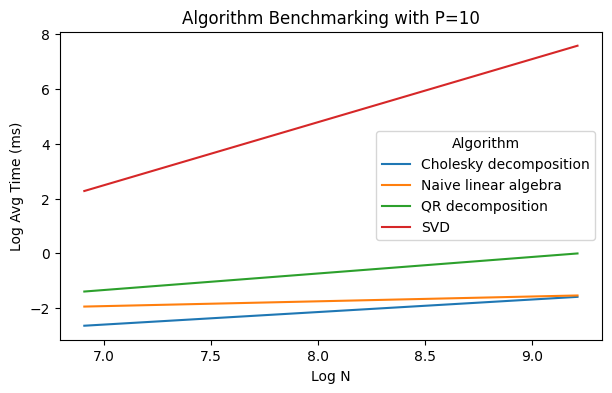

In [139]:
log_results_df = results_df.copy()
log_results_df['Avg Time (ms)'] = log_results_df['Avg Time (ms)'].astype("float")
log_results_df['N'] = log_results_df['N'].astype("float")
log_results_df['Log Avg Time (ms)'] = np.log(log_results_df['Avg Time (ms)'])
log_results_df['Log N'] = np.log(log_results_df['N'])
plot_df = log_results_df.pivot(index='Log N', columns='Algorithm', values='Log Avg Time (ms)')

plot_df.plot(figsize=(7, 4), ylabel="Log Avg Time (ms)", title="Algorithm Benchmarking with P=10")

## Q2

In [2]:
import pandas as pd

df = pd.read_csv("https://hastie.su.domains/ElemStatLearn/datasets/prostate.data", sep="\t", index_col=0)
df.reset_index(drop=True, inplace=True)
df.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason,pgg45,lpsa,train
0,-0.579818,2.769459,50,-1.386294,0,-1.386294,6,0,-0.430783,T
1,-0.994252,3.319626,58,-1.386294,0,-1.386294,6,0,-0.162519,T
2,-0.510826,2.691243,74,-1.386294,0,-1.386294,7,20,-0.162519,T
3,-1.203973,3.282789,58,-1.386294,0,-1.386294,6,0,-0.162519,T
4,0.751416,3.432373,62,-1.386294,0,-1.386294,6,0,0.371564,T


### Train test split

In [38]:
X_train = df[df.train=="T"].iloc[:,:7]
y_train = df[df.train=="T"].iloc[:,8]
X_test = df[df.train=="F"].iloc[:,:7]
y_test = df[df.train=="F"].iloc[:,8]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((67, 7), (67,), (30, 7), (30,))

### Feature scaling

We scale the features so that they have mean 0 and standard deviation $\sqrt{96} \approx 9.8$.

In [39]:
mean = X_train.mean()
std = X_train.std()

X_train = (X_train - mean) / std
X_train = X_train * np.sqrt(96) + 0

X_test = (X_test - mean) / std
X_test = X_test * np.sqrt(96) + 0

Let's check that `X_train` and `X_test` are scaled correctly.

In [40]:
X_train.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason
count,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01
mean,-5.832814e-16,-1.818777e-14,-7.980349e-15,5.302558e-16,-1.166563e-15,2.200561e-15,3.141765e-15
std,9.797959e+00,9.797959e+00,9.797959e+00,9.797959e+00,9.797959e+00,9.797959e+00,9.797959e+00
min,-2.097884e+01,-2.572221e+01,-3.101286e+01,-9.758325e+00,-5.222929e+00,-8.198625e+00,-1.010868e+01
25%,-6.506891e+00,-6.079992e+00,-4.892664e+00,-9.758325e+00,-5.222929e+00,-8.198625e+00,-1.010868e+01
50%,1.217325e+00,-5.638379e-01,3.313757e-01,-8.215973e-01,-5.222929e+00,-4.087135e+00,3.713391e+00
75%,8.165610e+00,5.293733e+00,5.555416e+00,9.881041e+00,-5.222929e+00,8.456766e+00,3.713391e+00
max,1.977200e+01,2.372959e+01,1.861552e+01,1.509443e+01,1.810615e+01,2.008199e+01,3.135752e+01


In [41]:
X_test.describe()

,lcavol,lweight,age,lbph,svi,lcp,gleason
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.931034,0.188443,-3.717255,0.625866,-0.557112,0.787909,0.948978
std,8.174025,6.186211,9.198831,9.668280,9.491160,9.886349,10.520312
min,-16.480036,-15.645743,-28.400844,-9.758325,-5.222929,-8.198625,-10.108675
25%,-4.076432,-3.011001,-6.198674,-9.758325,-5.222929,-8.198625,-10.108675
50%,1.033493,0.501776,-0.974634,2.455523,-5.222929,-1.514948,3.713391
75%,5.831936,4.352737,3.922903,10.050141,-5.222929,9.099812,3.713391
max,17.019807,10.183721,6.861426,14.057073,18.106155,21.812575,31.357523


### Data augmentation

We create new training data by adding Gaussian noises `X_noise` and `y_noise` to `X_train` and `y_train` respectively. We append the new data `X_new` and `y_new` to `X_train` and `y_train` respectively. By doing so, we obtain the augmented training data `y_train_aug` and `y_train_aug`.

In [70]:
np.random.seed(123)

# augmenting X_train
X_noise = np.random.normal(size=X_train.shape)
X_new = pd.DataFrame(X_train.values + X_noise, columns = X_train.columns)
X_train_aug = pd.concat([X_train, X_new])
X_train_aug.reset_index(drop=True, inplace=True)

# augmenting y_train
y_noise = np.random.normal(size=y_train.shape)
y_new = pd.Series(y_train.values + y_noise) #y_aug = pd.DataFrame(y_train.values + y_noise, columns = ["1psa"])
y_train_aug = pd.concat([y_train, y_new])
y_train_aug.reset_index(drop=True, inplace=True)

X_train_aug.shape, y_train_aug.shape

((134, 7), (134,))

Let's look at our augmented training data `X_train_aug` and `y_train_aug`.

In [71]:
X_train_aug.head()

,lcavol,lweight,age,lbph,svi,lcp,gleason
0,-14.928954,-17.610985,-19.258774,-9.758325,-5.222929,-8.198625,-10.108675
1,-18.196809,-6.300651,-8.810694,-9.758325,-5.222929,-8.198625,-10.108675
2,-14.384937,-19.218949,12.085466,-9.758325,-5.222929,-8.198625,3.713391
3,-19.850478,-7.057946,-8.810694,-9.758325,-5.222929,-8.198625,-10.108675
4,-4.432026,-3.982798,-3.586654,-9.758325,-5.222929,-8.198625,-10.108675


In [72]:
y_train_aug.head()

0   -0.430783
1   -0.162519
2   -0.162519
3   -0.162519
4    0.371564
dtype: float64

### Implement and compare two Ridge Regressions

In [92]:
from sklearn.linear_model import LinearRegression, Ridge


def ridge_benchmarking(method, X, y, alpha=1.0):
    
    if method == "Data augmentation":
        t = 0
        for i in range(100):
            start = time.time()
            model = LinearRegression()
            model.fit(X, y)
            end = time.time()
            t += end-start
            
    elif method == "Naive ridge":
        t = 0
        for i in range(100):
            start = time.time()
            model = Ridge(alpha=1.0)
            model.fit(X, y)
            end = time.time()
            t += end-start
        
    return model, t/100
    
# ridge regression by data augmentation    
rrda, t1 = ridge_benchmarking("Data augmentation", X_train_aug, y_train_aug)

# naive ridge regression
nrr, t2 = ridge_benchmarking("Naive ridge", X_train, y_train)

Compare their timing:

In [115]:
print(f"Ridge regression by data augmentation on average took {round(t1,5)} seconds for fitting the training data.")
print(f"Naive ridge regression on average took {round(t2,5)} seconds for fitting the training data.")

Ridge regression by data augmentation on average took 0.00139 seconds for fitting the training data.
Naive ridge regression on average took 0.00094 seconds for fitting the training data.


Compare the test results:

In [96]:
from sklearn.metrics import mean_squared_error

# ridge regression by data augmentation
y_pred = rrda.predict(X_test)
rmse_rrda = np.sqrt(mean_squared_error(y_pred, y_test))
print(f"Ridge regression by data augmentation has Root Mean Squared Error of {round(rmse_rrda,3)} on the test data.")

# naive ridge regression
y_pred = nrr.predict(X_test)
rmse_nrr = np.sqrt(mean_squared_error(y_pred, y_test))
print(f"Naive ridge regression has Root Mean Squared Error of {round(rmse_nrr,3)} on the test data.")

Ridge regression by data augmentation has Root Mean Squared Error of 0.712 on the test data.
Naive ridge regression has Root Mean Squared Error of 0.671 on the test data.


Therefore, for the `prostate cancer` dataset, Naive ridge regression on average is faster than Ridge regression by data augmentation, and it also produces smaller root mean squared error value.

## THE END